In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage

- * - * - * - * Beginning function call * - * - * - * -
~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...
Done.

~ ~ Performing category-level classification on single trials ~ ~ ...
(120, 5184)


/home/joannas/miniforge3/envs/eeg_analysis/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 50  36  34  55  27  37]
 [ 18 149  25  32  27  28]
 [ 42  28  77  36  37  34]
 [ 42  35  53  86  37  19]
 [ 37  32  51  45  47  37]
 [ 48  26  39  21  47  82]] (1556,) 1556
Done.

31.555269922879177
~ ~ Visualizing confusion matrix ~ ~ ...


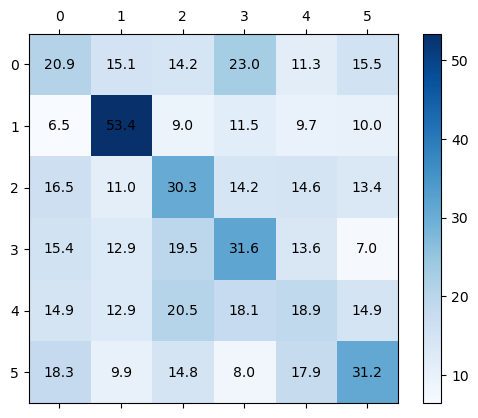

~ ~ Visualizing MDS plot ~ ~ ...
[[0.79079498 0.84937238 0.85774059 0.76987448 0.88702929 0.84518828]
 [0.93548387 0.46594982 0.91039427 0.88530466 0.90322581 0.89964158]
 [0.83464567 0.88976378 0.69685039 0.85826772 0.85433071 0.86614173]
 [0.84558824 0.87132353 0.80514706 0.68382353 0.86397059 0.93014706]
 [0.85140562 0.87148594 0.79518072 0.81927711 0.81124498 0.85140562]
 [0.81749049 0.90114068 0.85171103 0.92015209 0.82129278 0.68821293]]


ValueError: Distance matrix 'X' must be symmetric.

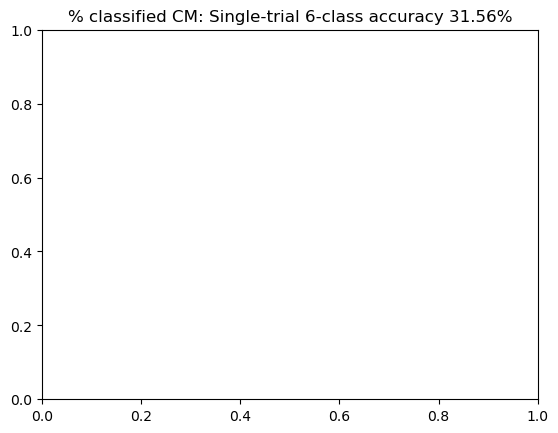

In [32]:
class MatClassRSA:
    class Preprocessing:
        @staticmethod
        def shuffleData(X, Y):
            idx = np.random.permutation(len(Y))
            return X[:, :, idx], Y[idx]
    class Classification:
        @staticmethod
        def crossValidateSingle(X, Y, method='PCA', variance=0.99, classifier='LDA',ch_num=85):
            lda = LDA()
            X_train, X_test, Y_train, Y_test = train_test_split(X[ch_num,:,:].T, Y, test_size=0.3)
            lda.fit(X_train, Y_train)
            Y_pred = lda.predict(X_test)
            cm = confusion_matrix(Y_test, Y_pred)
            print(cm)
            accuracy = np.mean(Y_test == Y_pred)
            return cm, accuracy
        @staticmethod
        def crossValidateMulti(X, Y, method='PCA', variance=0.99, classifier='LDA',chs=[96,32]):
            # pca = PCA(variance)
            # print(X.shape)
            # print((X.reshape(X.shape[0], -1).T).shape)
            # X_pca = pca.fit_transform(X.reshape(X.shape[0], -1).T).T
            # print(X_pca.reshape(X[]),Y.shape)
            # lda = LDA()
            # X_train, X_test, Y_train, Y_test = train_test_split(X_pca.T, Y, test_size=0.3)
            lda = LDA()
            feature_vector = np.concatenate([X[ch_num,:,:] for ch_num in chs],axis=0)
            X_train, X_test, Y_train, Y_test = train_test_split(feature_vector.T, Y, test_size=0.3)
            lda.fit(X_train, Y_train)
            Y_pred = lda.predict(X_test)
            cm = confusion_matrix(Y_test, Y_pred)
            accuracy = np.mean(Y_test.flatten() == Y_pred)
            return cm, accuracy
    class Visualization:
        @staticmethod
        def plotMatrix(cm, colorbar=True, matrixLabels=True, axisLabels=None, axisColors=None):
            fig, ax = plt.subplots()
            cax = ax.matshow(cm, cmap=plt.cm.Blues)
            if colorbar:
                plt.colorbar(cax)
            if matrixLabels:
                for (i, j), val in np.ndenumerate(cm):
                    ax.text(j, i, f'{val:.1f}', ha='center', va='center')
            if axisLabels:
                ax.set_xticklabels([''] + axisLabels)
                ax.set_yticklabels([''] + axisLabels)
            if axisColors:
                for ticklabel, tickcolor in zip(ax.get_xticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
                for ticklabel, tickcolor in zip(ax.get_yticklabels(), axisColors):
                    ticklabel.set_color(tickcolor)
            plt.show()
        @staticmethod
        def plotMDS(rdm, nodeLabels=None, nodeColors=None):
            mds = MDS(n_components=2, dissimilarity='precomputed')
            print(rdm)
            coords = mds.fit_transform(squareform(rdm))
            fig, ax = plt.subplots()
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=nodeColors, cmap='viridis')
            if nodeLabels:
                for i, label in enumerate(nodeLabels):
                    ax.text(coords[i, 0], coords[i, 1], label)
            plt.colorbar(sc)
            plt.show()
        @staticmethod
        def plotDendrogram(rdm, nodeLabels=None, nodeColors=None, yLim=None):
            linked = linkage(squareform(rdm), 'single')
            fig, ax = plt.subplots()
            dendro = dendrogram(linked, labels=nodeLabels, color_threshold=0, above_threshold_color='black', ax=ax)
            if yLim:
                plt.ylim(yLim)
            plt.show()
def load_data(pNum):
    X, labels6, labels72 = [], [], []
    if type(pNum) == int:
        pNum = [pNum]
    for i in pNum:
        baseFn = f'S{i:02d}.mat'
        data = sio.loadmat("./Data/"+baseFn)
        X.append(data['X'])
        labels6.append(data['labels6'])
        labels72.append(data['labels72'])
    X = np.concatenate(X, axis=2)
    labels6 = np.concatenate(labels6)
    labels72 = np.concatenate(labels72)
    return X, labels6, labels72, data['t'], data['fs']
def main(pNum, nCategories=6,channels=[85]):
    print('- * - * - * - * Beginning function call * - * - * - * -')
    assert isinstance(pNum, int) and pNum in range(11), 'The function requires one input (the participant number)'
    assert nCategories in [6, 72], 'Number of categories must be 6 or 72.'
    if pNum == 0:
        pNum = list(range(1, 11))
    X, labels6, labels72, t, fs = load_data(pNum)
    RSA = MatClassRSA()
    Y = labels6 if nCategories == 6 else labels72
    print('~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...')
    Xr, Yr = RSA.Preprocessing.shuffleData(X, Y)
    print('Done.\n')
    print('~ ~ Performing category-level classification on single trials ~ ~ ...')
    cm, accuracy = RSA.Classification.crossValidateMulti(Xr, Yr, 'PCA', 0.99, 'LDA',channels)
    print('Done.\n')
    cm_pct = 100 * cm / cm.sum(axis=1)[:, np.newaxis]
    accuracy_pct = accuracy * 100
    print(accuracy_pct)
    print('~ ~ Visualizing confusion matrix ~ ~ ...')
    RSA.Visualization.plotMatrix(cm_pct, colorbar=True, matrixLabels=True)
    plt.title(f'% classified CM: Single-trial 6-class accuracy {accuracy_pct:.2f}%')
    # plt.savefig(f'Figures/S{pNum:02d}_1a_singleTrialAllTime_CM.png')
    print('~ ~ Visualizing MDS plot ~ ~ ...')
    rdm = 1 - cm_pct / 100
    RSA.Visualization.plotMDS(rdm)
    print('~ ~ Visualizing Dendrogram ~ ~ ...')
    RSA.Visualization.plotDendrogram(rdm)
if __name__ == "__main__":
    pNum = 1
    nCategories = 6
    main(pNum, nCategories,[96,85,73])

- * - * - * - * Beginning function call * - * - * - * -
~ ~ Shuffling trials (paired with labels) to randomize order ~ ~ ...
Done.

~ ~ Performing category-level classification on single trials ~ ~ ...
(40, 5184)
Done.

16.51047276980723
~ ~ Visualizing confusion matrix ~ ~ ...


/home/joannas/miniforge3/envs/eeg_analysis/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


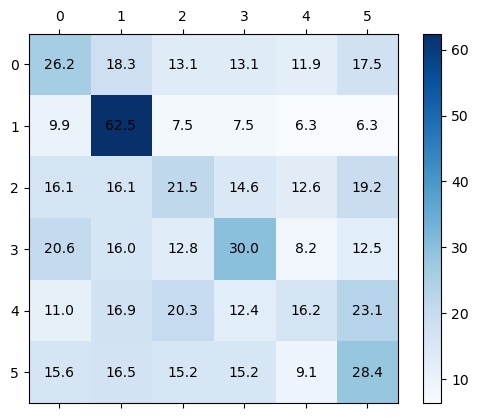

~ ~ Visualizing MDS plot ~ ~ ...
[[0.73809524 0.81746032 0.86904762 0.86904762 0.88095238 0.82539683]
 [0.90118577 0.37549407 0.92490119 0.92490119 0.93675889 0.93675889]
 [0.83908046 0.83908046 0.78544061 0.85440613 0.87356322 0.80842912]
 [0.79377432 0.84046693 0.87159533 0.70038911 0.91828794 0.87548638]
 [0.88965517 0.83103448 0.79655172 0.87586207 0.83793103 0.76896552]
 [0.8436214  0.83539095 0.84773663 0.84773663 0.90946502 0.71604938]]


ValueError: Distance matrix 'X' must be symmetric.

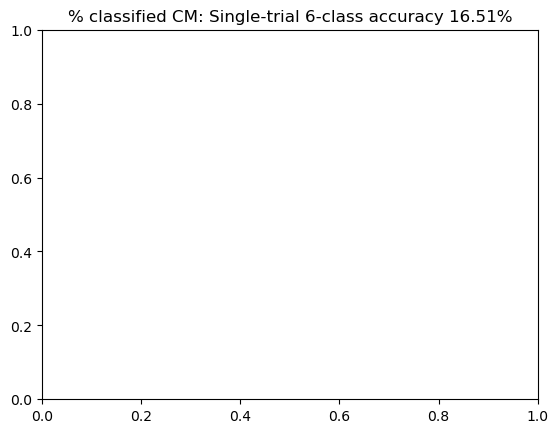

In [24]:
main(pNum, nCategories,[96])
